In [1]:
from odes.models import SIR
from odes.integrator import integrator
from odes.neural_ODE import nUIV_NODE
import torch
# import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# helper function to step the SIR model forward and generate a data set
def generate_SIR_data(model, num_steps):
    t = torch.zeros(num_steps)
    y = torch.zeros(3, num_steps)
    y[:, 0] = torch.from_numpy(model.x)
    t[0] = torch.tensor(0.0)
    for i in range(num_steps):
        y[:, i] = torch.from_numpy(model.step())
        t[i] = torch.tensor(model.t)
    return y, t


def lp_norm_loss(y, yhat, p=2):
    return torch.norm(y-yhat, p=p)

In [3]:
# setting up SIR reference data
num_hosts = 50
num_steps = 400
dt = 0.05
torch.manual_seed(666)

time_scale = 25.0  # can make time "move faster" by scaling these constants beyond [0, 1]
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.75, 0.25, 0.0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

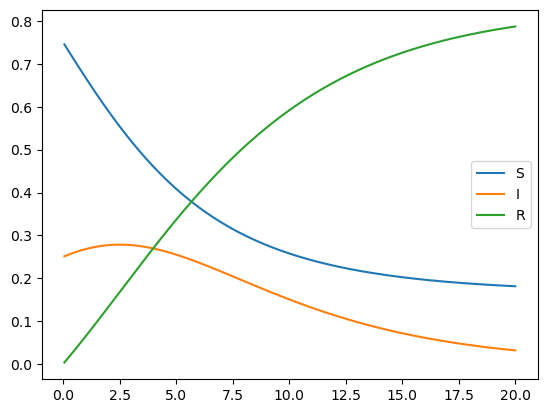

In [4]:
plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [5]:
num_epochs = 200

method = 'euler'
step_size = 2*dt
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nUIV_NODE(num_hosts, method=method, step_size=step_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

loss_function = lambda y, yhat: lp_norm_loss(y, yhat, p=2)  # nn.L1Loss()

y_train = torch.cat((SIR_train_data[0,:], SIR_train_data[1,:], SIR_train_data[2,:]))

In [7]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    y_est = torch.cat((SIR_est[0,:], SIR_est[1,:], SIR_est[2,:]))
    loss = loss_function(y_est, y_train.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')

Epoch 0, loss value: 18.340818405151367.
Epoch 1, loss value: 11.456690788269043.
Epoch 2, loss value: 9.929654121398926.
Epoch 3, loss value: 7.344893932342529.
Epoch 4, loss value: 3.759169101715088.
Epoch 5, loss value: 7.275230884552002.
Epoch 6, loss value: 4.851724147796631.
Epoch 7, loss value: 3.490354299545288.
Epoch 8, loss value: 4.533560752868652.
Epoch 9, loss value: 4.394802093505859.
Epoch 10, loss value: 3.15423321723938.
Epoch 11, loss value: 1.8877832889556885.
Epoch 12, loss value: 2.901440382003784.
Epoch 13, loss value: 2.298780679702759.
Epoch 14, loss value: 1.440659999847412.
Epoch 15, loss value: 2.118652582168579.
Epoch 16, loss value: 1.8386064767837524.
Epoch 17, loss value: 1.4061975479125977.
Epoch 18, loss value: 1.6766953468322754.
Epoch 19, loss value: 1.3220391273498535.
Epoch 20, loss value: 1.3368092775344849.
Epoch 21, loss value: 1.180695652961731.
Epoch 22, loss value: 1.3892312049865723.
Epoch 23, loss value: 1.1675388813018799.
Epoch 24, loss va

In [8]:
nUIV_params = model.get_params()
SIR_params = {'beta': beta,
              'gamma': gamma,
              'x0': SIR_x0,
              'num_hosts': num_hosts}

sim_params = {'SIR': SIR_params,
              'nUIV': nUIV_params}

print(nUIV_params)

{'beta': array([3.0126682e-01, 1.6876584e+00, 3.1176381e-02, 2.1492074e+00,
       1.7317706e+00, 5.4771233e-01, 1.7030100e+00, 1.3310477e+00,
       1.4346204e+00, 2.7068834e+00, 1.5643754e+00, 2.4547105e+00,
       2.8279567e-02, 1.9206055e+00, 2.3886721e+00, 1.0362092e+00,
       1.6220794e+00, 4.5785472e-01, 1.1573048e+00, 3.3183209e-05,
       1.0684434e-01, 1.5285008e-01, 7.3521513e-01, 7.1991038e-01,
       4.7243181e-01, 1.1154754e+00, 1.5806016e+00, 1.8243088e-01,
       2.7150981e+00, 4.6745509e-01, 3.4866652e+00, 1.5827875e+00,
       1.4147999e+00, 1.2853514e+00, 6.8075442e-01, 8.4004462e-01,
       1.4242483e+00, 1.7925088e+00, 8.0152029e-01, 4.4602659e-01,
       1.5719129e+00, 1.0242050e+00, 2.4766152e+00, 3.6331001e-01,
       3.0972180e+00, 9.2301749e-02, 3.0586743e+00, 1.8434286e+00,
       7.7175770e-05, 3.0940104e-01], dtype=float32), 'delta': array([4.6694614e-02, 2.5515549e+00, 3.9768409e-02, 4.0991902e-03,
       5.0755543e-01, 5.7152968e-02, 1.6960995e+00, 2.254

Resetting to stored initial state.
Resetting to t=0.0.


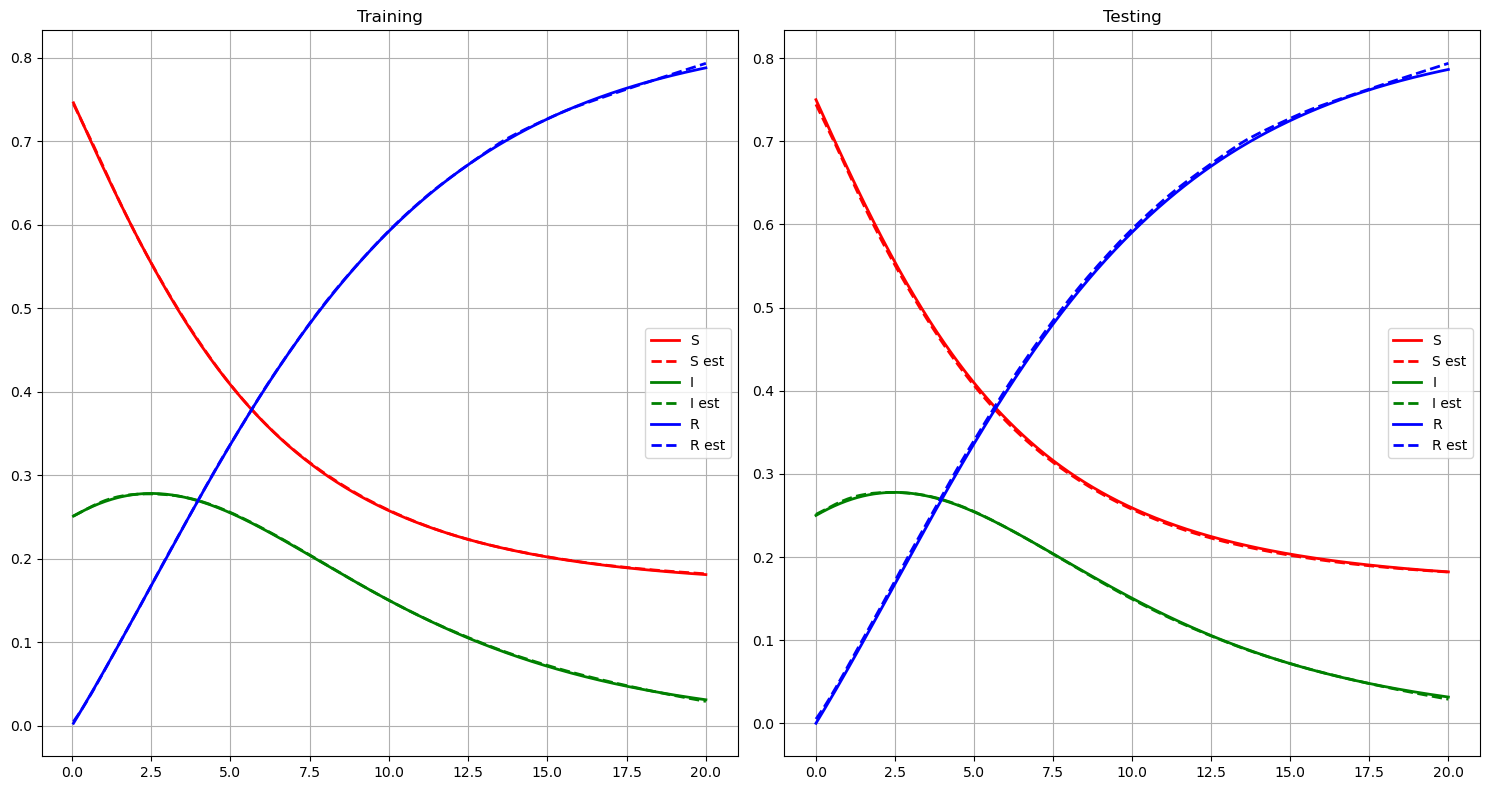

In [9]:
SIR_stepper.reset()
SIR_stepper.dt = 0.001
num_steps = 20000
SIR_test_data, time_test_data = generate_SIR_data(SIR_stepper, num_steps)

with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()
    SIR_test_data_est = model.simulate(time_test_data.to(device)).detach().cpu().numpy()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']

for i, name in enumerate(names):
    ax1.plot(time_train_data, SIR_train_data[i, :], lw=2, color=colors[i], label=name)
    ax1.plot(time_train_data, SIR_train_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
    ax2.plot(time_test_data, SIR_test_data[i, :], lw=2, color=colors[i], label=name)
    ax2.plot(time_test_data, SIR_test_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')


# ax1.plot(time_train_data[3:], SIR_train_data[1, 3:], lw=2, color=colors[1], label=names[1])
# ax1.plot(time_train_data[3:], SIR_train_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
# ax2.plot(time_test_data[3:], SIR_test_data[1, 3:], lw=2, color=colors[1], label=names[1])
# ax2.plot(time_test_data[3:], SIR_test_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax1.set_title('Training')
ax2.set_title('Testing')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
f.tight_layout()

path = './tmp/'
if not os.path.exists(path):
    os.mkdir(path)
filename = os.path.join(path, 'last_run_pytorch.png')
f.savefig(filename)
plt.show()